In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 26.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [ ]:
from datetime import timedelta
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
import optuna

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

In [ ]:
import xgboost as xgb

In [ ]:
from google.colab import files

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import QuantileTransformer

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from xgboost.callback import EarlyStopping

# Prepared Data Import

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Big_Mart_Sales_Prediction_ABB_Assignment/Big_Mart_Prepared_Data_Train_Test.csv")

In [ ]:
df.head(3)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,train_data,Item_Group,Outlet_Age,Item_Prefix,Item_Visibility_Adjusted,Item_Visibility_MeanRatio,Price_Per_Weight,MRP_bin,Intr_Item_MRP_Item_Visibility,Intr_Outlet_Age_Outlet_Size
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,1,Fresh Foods_Veg,14,FD,0.000160,0.931078,26.861204,4,4.008763,14_Medium
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,1,Beverages,4,DR,0.000193,0.933420,8.153581,0,0.930544,4_Medium
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,1,Fresh Foods_Non_Veg,14,FD,0.000168,0.875933,8.092457,2,2.373528,14_Medium


# Sales Distribution Check

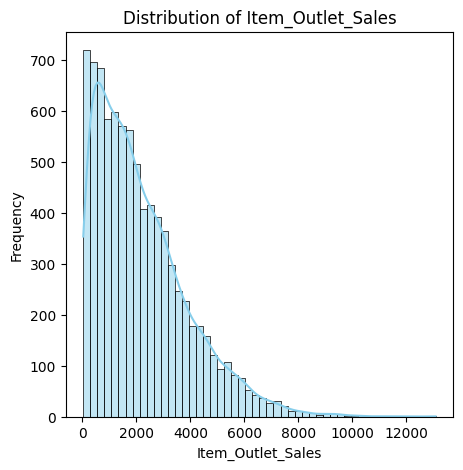

In [ ]:
plt.figure(figsize=(5,5))
sns.histplot(df["Item_Outlet_Sales"], bins=50, kde=True, color="skyblue")
plt.title("Distribution of Item_Outlet_Sales")
plt.xlabel("Item_Outlet_Sales")
plt.ylabel("Frequency")
plt.show()

As this is highly skewes, it can hamper model's learning. We have to either apply Square-Root or Quantile Transformation to reduce the skewness

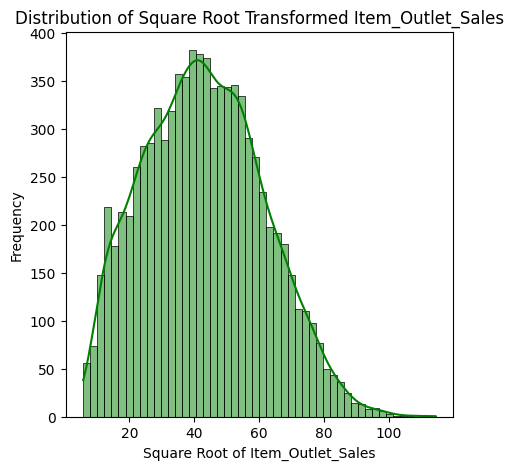

In [ ]:
plt.figure(figsize=(5,5))
sns.histplot(np.sqrt(df["Item_Outlet_Sales"]), bins=50, kde=True, color="green")
plt.title("Distribution of Square Root Transformed Item_Outlet_Sales")
plt.xlabel("Square Root of Item_Outlet_Sales")
plt.ylabel("Frequency")
plt.show()

As this reduces the skewness, we'll apply sqrt transformation during our model training.

# Train, Test, Validation Split

In [ ]:
train = df[df['train_data']==1]
test = df[df['train_data']==0]

In [ ]:
num_features = ['Item_Weight','Item_Visibility','Item_MRP','Outlet_Age','Item_Visibility_Adjusted',
                'Item_Visibility_MeanRatio','Price_Per_Weight','Intr_Item_MRP_Item_Visibility']

cat_features = ['Item_Fat_Content','Item_Type','Outlet_Type','Outlet_Location_Type',
                'Outlet_Size', 'MRP_bin','Intr_Outlet_Age_Outlet_Size','Outlet_Identifier']

In [ ]:
X_train = train[num_features + cat_features]
y_train = np.sqrt(train['Item_Outlet_Sales'])

X_test = test[num_features + cat_features]

As there are many categorical column, we'll convert them to 'Category' as our XGBoost Model needs these column in that data type

In [ ]:
for col in cat_features:
  X_train[col] = X_train[col].astype("category")
  X_test[col] = X_test[col].astype("category")

/tmp/ipython-input-2119570761.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col].astype("category")
/tmp/ipython-input-2119570761.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = X_test[col].astype("category")
/tmp/ipython-input-2119570761.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [ ]:
X_train_mod, X_val, y_train_mod, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Hyper-Parameter Tuning

In [44]:
def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "booster": trial.suggest_categorical("booster", ["gbtree"]),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.2, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "lambda": trial.suggest_float("lambda", 1e-3, 5.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-4, 5.0, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 300, 1500, step=100),
    }

    # Cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []

    for train_idx, valid_idx in kf.split(X_train_mod):
        X_train_opt, X_valid_opt = X_train_mod.iloc[train_idx], X_train_mod.iloc[valid_idx]
        y_train_opt, y_valid_opt = y_train_mod.iloc[train_idx], y_train_mod.iloc[valid_idx]

        model = xgb.XGBRegressor(**params, random_state=42, n_jobs=-1, enable_categorical=True)

        model.fit(
            X_train_opt, y_train_opt,
            eval_set=[(X_valid_opt, y_valid_opt)],
            verbose=False
        )

        preds = model.predict(X_valid_opt)

        preds_transformed = np.square(preds)
        y_valid_opt_transformed = np.square(y_valid_opt)

        rmse = np.sqrt(mean_squared_error(y_valid_opt_transformed, preds_transformed))
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)

In [45]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=75)

[I 2025-09-13 18:15:20,880] A new study created in memory with name: no-name-31c50a3f-0432-46de-9d8e-f7c4a63388bf
[I 2025-09-13 18:15:46,263] Trial 0 finished with value: 1241.330828304603 and parameters: {'booster': 'gbtree', 'learning_rate': 0.042129378808239346, 'max_depth': 8, 'min_child_weight': 7, 'subsample': 0.610553903635211, 'colsample_bytree': 0.8883713289094943, 'lambda': 0.009981216867853918, 'alpha': 0.004596905008223416, 'n_estimators': 700}. Best is trial 0 with value: 1241.330828304603.
[I 2025-09-13 18:15:58,479] Trial 1 finished with value: 1280.5316387528285 and parameters: {'booster': 'gbtree', 'learning_rate': 0.19026405746020106, 'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.8556534325773837, 'colsample_bytree': 0.7151910898188912, 'lambda': 0.09799001645767288, 'alpha': 0.0002772323800040639, 'n_estimators': 500}. Best is trial 0 with value: 1241.330828304603.
[I 2025-09-13 18:16:11,340] Trial 2 finished with value: 1234.3346350957759 and parameters: {'b

In [46]:
print("Best RMSE:", study.best_value)
print("Best hyperparameters:", study.best_params)

Best RMSE: 1101.0766747703517
Best hyperparameters: {'booster': 'gbtree', 'learning_rate': 0.006139260762758096, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.7760852083606415, 'colsample_bytree': 0.9826379579545146, 'lambda': 0.0031409636738964713, 'alpha': 0.032044370603475605, 'n_estimators': 1000}


# Building Model With Tuned Parameters

In [47]:
best_params = study.best_params

In [48]:
xgb_model = xgb.XGBRegressor(
    **best_params,
    random_state=42,
    n_jobs=-1,
    enable_categorical=True
)

In [49]:
xgb_model.fit(
    X_train_mod, y_train_mod,
    verbose=False
)

XGBRegressor(alpha=0.032044370603475605, base_score=None, booster='gbtree',
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9826379579545146, device=None,
             early_stopping_rounds=None, enable_categorical=True,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=0.0031409636738964713,
             learning_rate=0.006139260762758096, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, ...)

# Performance on Unseen Validation Data

In [50]:
y_train_pred_sqrt = xgb_model.predict(X_train_mod)
y_val_pred_sqrt = xgb_model.predict(X_val)

In [51]:
y_train_pred = np.square(y_train_pred_sqrt)
y_val_pred = np.square(y_val_pred_sqrt)

In [52]:
y_train_true = np.square(y_train_mod)
y_val_true = np.square(y_val)

In [53]:
train_rmse = np.sqrt(mean_squared_error(y_train_true, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val_true, y_val_pred))

# R²
train_r2 = r2_score(y_train_true, y_train_pred)
val_r2 = r2_score(y_val_true, y_val_pred)

print(f"Train RMSE: {train_rmse:.2f}, R²: {train_r2:.4f}")
print(f"Valid RMSE: {val_rmse:.2f}, R²: {val_r2:.4f}")

Train RMSE: 1061.16, R²: 0.6193
Valid RMSE: 1027.07, R²: 0.6119


Model is able to generalize quite well on the unseen data. No issues of overfitting is detected.

# Model Diagnostics

Text(0.5, 1.0, 'True vs Predicted')

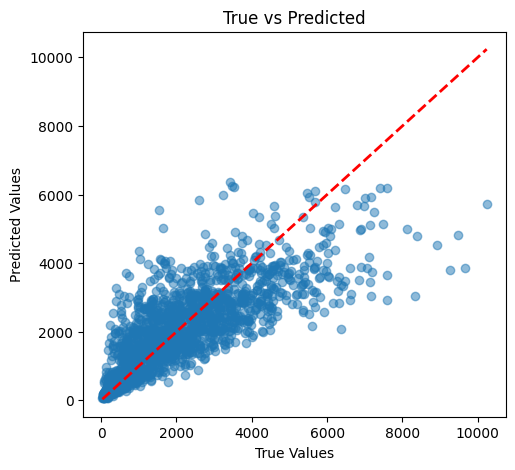

In [54]:
# Scatter plot: True vs Predicted
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_val_true, y_val_pred, alpha=0.5)
plt.plot([y_val_true.min(), y_val_true.max()],
         [y_val_true.min(), y_val_true.max()],
         color="red", linestyle="--", linewidth=2)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted")

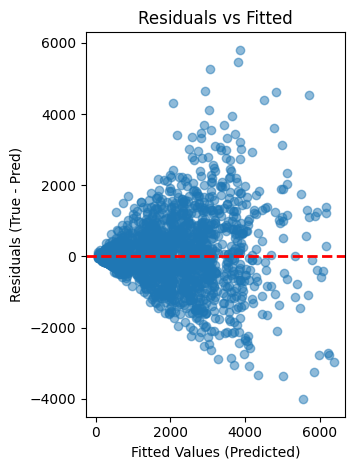

In [55]:
residuals = y_val_true - y_val_pred

plt.subplot(1, 2, 2)
plt.scatter(y_val_pred, residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--", linewidth=2)
plt.xlabel("Fitted Values (Predicted)")
plt.ylabel("Residuals (True - Pred)")
plt.title("Residuals vs Fitted")

plt.tight_layout()
plt.show()

A funnel-shaped residual plot is a classic sign of heteroscedasticity. In this case, as the funnel widens for higher predictions, it means the model is underestimating variability for high-sales products. We'll try weighted loss approach in XGBoost to see if we can mitigate the issue

# Hyper-Parameter Tuning for XGB with Weighted Loss

In [56]:
def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "booster": trial.suggest_categorical("booster", ["gbtree"]),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.2, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "lambda": trial.suggest_float("lambda", 1e-3, 5.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-4, 5.0, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 300, 1500, step=100),
    }

    # Cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []

    for train_idx, valid_idx in kf.split(X_train_mod):
        X_train_opt, X_valid_opt = X_train_mod.iloc[train_idx], X_train_mod.iloc[valid_idx]
        y_train_opt, y_valid_opt = y_train_mod.iloc[train_idx], y_train_mod.iloc[valid_idx]

        sample_weights = y_train_opt.values + 1e-6 # Weights for each sample
        sample_weights /= sample_weights.mean() # Normalizing weights

        model = xgb.XGBRegressor(**params, random_state=42, n_jobs=-1, enable_categorical=True)

        model.fit(
            X_train_opt, y_train_opt,
            eval_set=[(X_valid_opt, y_valid_opt)],
            verbose=False,
            sample_weight=sample_weights
        )

        preds = model.predict(X_valid_opt)

        preds_transformed = np.square(preds)
        y_valid_opt_transformed = np.square(y_valid_opt)

        rmse = np.sqrt(mean_squared_error(y_valid_opt_transformed, preds_transformed))
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)

In [57]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=75)

[I 2025-09-13 18:47:27,828] A new study created in memory with name: no-name-5ccd1871-556f-4bef-b471-dcc99d0dbdca
[I 2025-09-13 18:47:49,960] Trial 0 finished with value: 1182.8584351961895 and parameters: {'booster': 'gbtree', 'learning_rate': 0.02186211850397292, 'max_depth': 8, 'min_child_weight': 6, 'subsample': 0.9467247781770672, 'colsample_bytree': 0.7060648767906841, 'lambda': 0.012696271618575124, 'alpha': 0.0035568875103327976, 'n_estimators': 700}. Best is trial 0 with value: 1182.8584351961895.
[I 2025-09-13 18:47:53,623] Trial 1 finished with value: 1128.4443611217037 and parameters: {'booster': 'gbtree', 'learning_rate': 0.04919214348981577, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.76728813025295, 'colsample_bytree': 0.9609984489867632, 'lambda': 0.0022211758254946003, 'alpha': 0.0017829539738430163, 'n_estimators': 500}. Best is trial 1 with value: 1128.4443611217037.
[I 2025-09-13 18:48:01,409] Trial 2 finished with value: 1114.4487719956912 and parameters:

In [58]:
print("Best RMSE:", study.best_value)
print("Best hyperparameters:", study.best_params)

Best RMSE: 1096.5533943565881
Best hyperparameters: {'booster': 'gbtree', 'learning_rate': 0.005741675335670549, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.7093102278461456, 'colsample_bytree': 0.8149973612146555, 'lambda': 0.007938733233352932, 'alpha': 0.00021773776135105007, 'n_estimators': 700}


In [59]:
best_params = study.best_params

In [60]:
sample_weights = y_train_mod.values + 1e-6
sample_weights /= sample_weights.mean()

In [61]:
xgb_model_wt = xgb.XGBRegressor(
    **best_params,
    random_state=42,
    n_jobs=-1,
    enable_categorical=True
)

In [62]:
xgb_model_wt.fit(
    X_train_mod, y_train_mod,
    verbose=False,
    sample_weight=sample_weights
)

XGBRegressor(alpha=0.00021773776135105007, base_score=None, booster='gbtree',
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8149973612146555, device=None,
             early_stopping_rounds=None, enable_categorical=True,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=0.007938733233352932,
             learning_rate=0.005741675335670549, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=700, ...)

In [63]:
y_train_pred_sqrt = xgb_model_wt.predict(X_train_mod)
y_val_pred_sqrt = xgb_model_wt.predict(X_val)

y_train_pred = np.square(y_train_pred_sqrt)
y_val_pred = np.square(y_val_pred_sqrt)

y_train_true = np.square(y_train_mod)
y_val_true = np.square(y_val)

train_rmse = np.sqrt(mean_squared_error(y_train_true, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val_true, y_val_pred))

# R²
train_r2 = r2_score(y_train_true, y_train_pred)
val_r2 = r2_score(y_val_true, y_val_pred)

print(f"Train RMSE: {train_rmse:.2f}, R²: {train_r2:.4f}")
print(f"Valid RMSE: {val_rmse:.2f}, R²: {val_r2:.4f}")

Train RMSE: 1070.59, R²: 0.6125
Valid RMSE: 1027.38, R²: 0.6117


Text(0.5, 1.0, 'True vs Predicted')

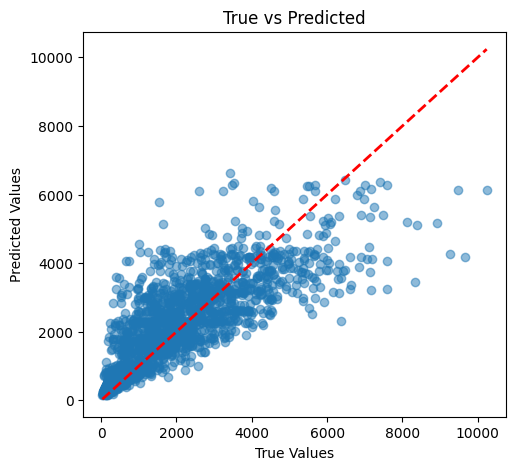

In [64]:
# Scatter plot: True vs Predicted
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_val_true, y_val_pred, alpha=0.5)
plt.plot([y_val_true.min(), y_val_true.max()],
         [y_val_true.min(), y_val_true.max()],
         color="red", linestyle="--", linewidth=2)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted")

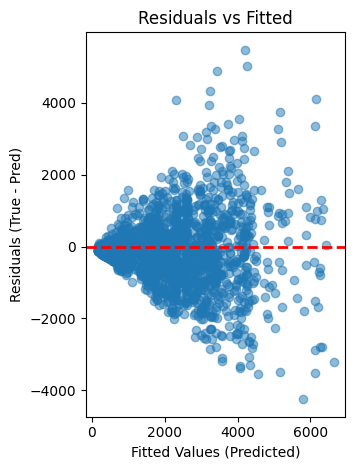

In [65]:
residuals = y_val_true - y_val_pred

plt.subplot(1, 2, 2)
plt.scatter(y_val_pred, residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--", linewidth=2)
plt.xlabel("Fitted Values (Predicted)")
plt.ylabel("Residuals (True - Pred)")
plt.title("Residuals vs Fitted")

plt.tight_layout()
plt.show()

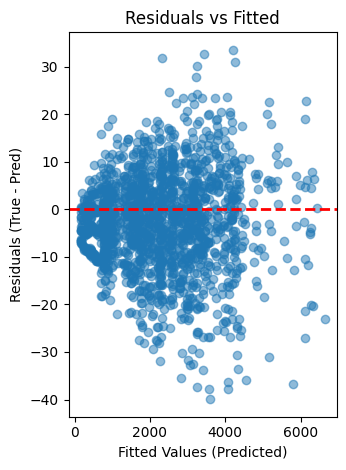

In [66]:
residuals = y_val - y_val_pred_sqrt

plt.subplot(1, 2, 2)
plt.scatter(y_val_pred, residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--", linewidth=2)
plt.xlabel("Fitted Values (Predicted)")
plt.ylabel("Residuals (True - Pred)")
plt.title("Residuals vs Fitted")

plt.tight_layout()
plt.show()

Funnel shape persists even after weighting, it means the model cannot fully capture the increasing variance just by weighting. This usually calls for approaches that explicitly model heteroscedasticity.

# Quantile Regression with XGB

In [74]:
def objective(trial):
    params = {
        "objective": "reg:quantileerror",
        "quantile_alpha": trial.suggest_float("quantile_alpha", 0.5, 0.8),
        "eval_metric": "rmse",
        "booster": trial.suggest_categorical("booster", ["gbtree"]),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.2, log=True),
        "max_depth": trial.suggest_int("max_depth", 4, 8),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "lambda": trial.suggest_float("lambda", 1e-3, 5.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-4, 5.0, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 300, 1500, step=100),
    }

    # Cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []

    for train_idx, valid_idx in kf.split(X_train_mod):
        X_train_opt, X_valid_opt = X_train_mod.iloc[train_idx], X_train_mod.iloc[valid_idx]
        y_train_opt, y_valid_opt = y_train_mod.iloc[train_idx], y_train_mod.iloc[valid_idx]

        model = xgb.XGBRegressor(**params, random_state=42, n_jobs=-1, enable_categorical=True)

        model.fit(
            X_train_opt, y_train_opt,
            eval_set=[(X_valid_opt, y_valid_opt)],
            verbose=False
        )

        preds = model.predict(X_valid_opt)

        preds_transformed = np.square(preds)
        y_valid_opt_transformed = np.square(y_valid_opt)

        rmse = np.sqrt(mean_squared_error(y_valid_opt_transformed, preds_transformed))
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)

In [75]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=75)

[I 2025-09-13 19:27:55,230] A new study created in memory with name: no-name-beec277a-3d73-4636-b529-b323d141063a
[I 2025-09-13 19:28:05,751] Trial 0 finished with value: 1193.3441807332533 and parameters: {'quantile_alpha': 0.7081061189508695, 'booster': 'gbtree', 'learning_rate': 0.006074646071650718, 'max_depth': 6, 'min_child_weight': 5, 'subsample': 0.6667841858743927, 'colsample_bytree': 0.9666832740014821, 'lambda': 0.2600370693320358, 'alpha': 2.2963233515678714, 'n_estimators': 400}. Best is trial 0 with value: 1193.3441807332533.
[I 2025-09-13 19:28:22,000] Trial 1 finished with value: 1264.0985395368295 and parameters: {'quantile_alpha': 0.7393202676380383, 'booster': 'gbtree', 'learning_rate': 0.005997114486094281, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.6785673480655416, 'colsample_bytree': 0.6393066028936562, 'lambda': 0.07468429636333201, 'alpha': 0.0018106890586364573, 'n_estimators': 1100}. Best is trial 0 with value: 1193.3441807332533.
[I 2025-09-13 19:

In [76]:
print("Best RMSE:", study.best_value)
print("Best hyperparameters:", study.best_params)

Best RMSE: 1095.4090233620273
Best hyperparameters: {'quantile_alpha': 0.5420684009876187, 'booster': 'gbtree', 'learning_rate': 0.006107542665675147, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.6930365701729079, 'colsample_bytree': 0.9799657711863665, 'lambda': 0.04607875255351679, 'alpha': 0.000657884128081164, 'n_estimators': 900}


In [77]:
best_params = study.best_params

In [83]:
xgb_model_qn = xgb.XGBRegressor(
    **best_params,
    random_state=42,
    n_jobs=-1,
    enable_categorical=True,
    objective= "reg:quantileerror")

In [84]:
xgb_model_qn.fit(
    X_train_mod, y_train_mod,
    verbose=False)

XGBRegressor(alpha=0.000657884128081164, base_score=None, booster='gbtree',
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9799657711863665, device=None,
             early_stopping_rounds=None, enable_categorical=True,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=0.04607875255351679,
             learning_rate=0.006107542665675147, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=900, ...)

In [85]:
y_train_pred_sqrt = xgb_model_qn.predict(X_train_mod)
y_val_pred_sqrt = xgb_model_qn.predict(X_val)

y_train_pred = np.square(y_train_pred_sqrt)
y_val_pred = np.square(y_val_pred_sqrt)

y_train_true = np.square(y_train_mod)
y_val_true = np.square(y_val)

train_rmse = np.sqrt(mean_squared_error(y_train_true, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val_true, y_val_pred))

# R²
train_r2 = r2_score(y_train_true, y_train_pred)
val_r2 = r2_score(y_val_true, y_val_pred)

print(f"Train RMSE: {train_rmse:.2f}, R²: {train_r2:.4f}")
print(f"Valid RMSE: {val_rmse:.2f}, R²: {val_r2:.4f}")

Train RMSE: 1058.44, R²: 0.6213
Valid RMSE: 1021.09, R²: 0.6164


Text(0.5, 1.0, 'True vs Predicted')

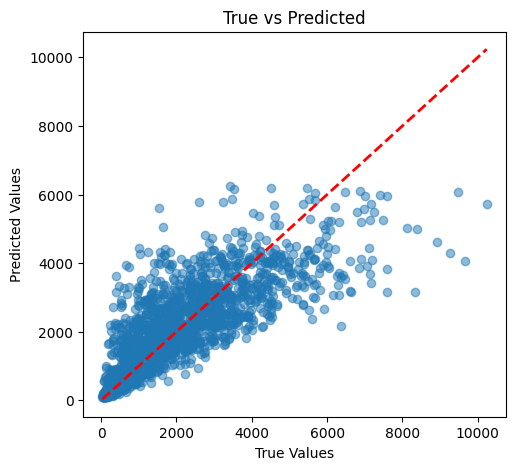

In [86]:
# Scatter plot: True vs Predicted
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_val_true, y_val_pred, alpha=0.5)
plt.plot([y_val_true.min(), y_val_true.max()],
         [y_val_true.min(), y_val_true.max()],
         color="red", linestyle="--", linewidth=2)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted")

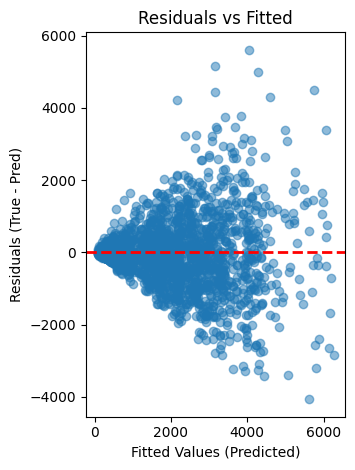

In [87]:
residuals = y_val_true - y_val_pred

plt.subplot(1, 2, 2)
plt.scatter(y_val_pred, residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--", linewidth=2)
plt.xlabel("Fitted Values (Predicted)")
plt.ylabel("Residuals (True - Pred)")
plt.title("Residuals vs Fitted")

plt.tight_layout()
plt.show()

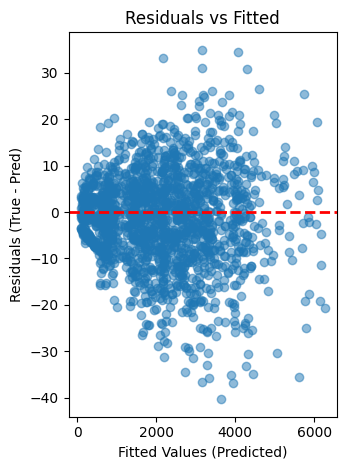

In [88]:
residuals = y_val - y_val_pred_sqrt

plt.subplot(1, 2, 2)
plt.scatter(y_val_pred, residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--", linewidth=2)
plt.xlabel("Fitted Values (Predicted)")
plt.ylabel("Residuals (True - Pred)")
plt.title("Residuals vs Fitted")

plt.tight_layout()
plt.show()

# Quantile XGB Regressor with Box-Cox Transformation

In [89]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox

In [90]:
y_train_mod_bc, lambda_bc = boxcox(y_train_mod + 1e-6)

In [91]:
print("Optimal Box-Cox λ:", lambda_bc)

Optimal Box-Cox λ: 0.693529468606746


In [128]:
xgb_model_qn_bc = xgb.XGBRegressor(
    **best_params,
    random_state=42,
    n_jobs=-1,
    enable_categorical=True,
    objective= "reg:quantileerror")

In [129]:
xgb_model_qn_bc.fit(
    X_train_mod, y_train_mod_bc,
    verbose=False)

XGBRegressor(alpha=0.000657884128081164, base_score=None, booster='gbtree',
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9799657711863665, device=None,
             early_stopping_rounds=None, enable_categorical=True,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=0.04607875255351679,
             learning_rate=0.006107542665675147, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=900, ...)

In [130]:
y_train_pred_sqrt_bc = xgb_model_qn_bc.predict(X_train_mod)
y_val_pred_sqrt_bc = xgb_model_qn_bc.predict(X_val)

y_train_pred = np.square(inv_boxcox(y_train_pred_sqrt_bc, lambda_bc))
y_val_pred = np.square(inv_boxcox(y_val_pred_sqrt_bc, lambda_bc))

y_train_true = np.square(y_train_mod)
y_val_true = np.square(y_val)

train_rmse = np.sqrt(mean_squared_error(y_train_true, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val_true, y_val_pred))

# R²
train_r2 = r2_score(y_train_true, y_train_pred)
val_r2 = r2_score(y_val_true, y_val_pred)

print(f"Train RMSE: {train_rmse:.2f}, R²: {train_r2:.4f}")
print(f"Valid RMSE: {val_rmse:.2f}, R²: {val_r2:.4f}")

Train RMSE: 1057.61, R²: 0.6219
Valid RMSE: 1021.05, R²: 0.6164


Text(0.5, 1.0, 'True vs Predicted')

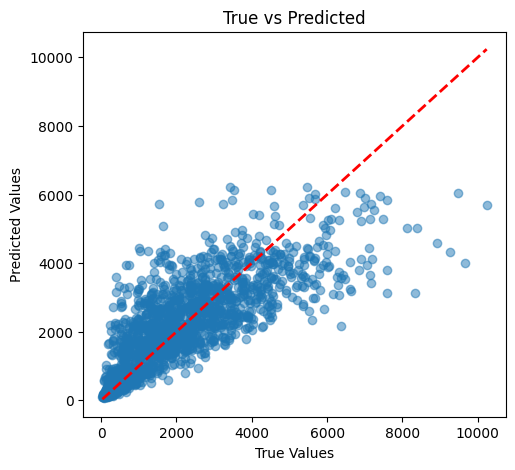

In [131]:
# Scatter plot: True vs Predicted
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_val_true, y_val_pred, alpha=0.5)
plt.plot([y_val_true.min(), y_val_true.max()],
         [y_val_true.min(), y_val_true.max()],
         color="red", linestyle="--", linewidth=2)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted")

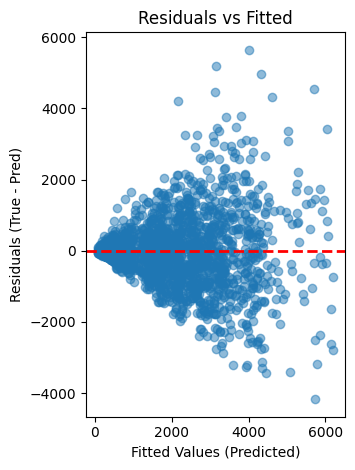

In [132]:
residuals = y_val_true - y_val_pred

plt.subplot(1, 2, 2)
plt.scatter(y_val_pred, residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--", linewidth=2)
plt.xlabel("Fitted Values (Predicted)")
plt.ylabel("Residuals (True - Pred)")
plt.title("Residuals vs Fitted")

plt.tight_layout()
plt.show()

To some extent, we have reduced the Heteroscedasticity. But issue still remains.

Prediction for Test Data

In [133]:
y_test_pred_sqrt_bc = xgb_model_qn_bc.predict(X_test)
y_test_pred = np.square(inv_boxcox(y_test_pred_sqrt_bc, lambda_bc))

In [134]:
df_test_pred = pd.DataFrame({
    "Item_Identifier": test["Item_Identifier"],
    "Outlet_Identifier": test["Outlet_Identifier"],
    "Item_Outlet_Sales": y_test_pred
})

df_test_pred["Item_Outlet_Sales"] = round(df_test_pred["Item_Outlet_Sales"])

In [135]:
df_test_pred.to_csv("Big_Mart_Submission_Final.csv", index=False)
files.download("Big_Mart_Submission_Final.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>